# Second report of lyrics dataset

After preprocessing and analyzing our dataset in the first report, we will now create a model. Our model will predict the genre and interpreter based on lyrics.

First, we will enhance preprocessing with additional transformations and add language prediction as a useful feature. Then we will try a few different models and find out which one performs the best. Then we will see the performance of the model.

1. [Preprocessing: featurization](#preprocessing-featurization)
2. [Model creation](#model-creation)
3. [Model results](#model-results)
4. [Conclusion](#conclusion)

This time, preprocessing and modelling have been moved to separate notebooks, so you can see them if you are interested in the code.

## 1. Preprocessing: featurization

We need to prepare our data for modelling. We will create 2 models: genre prediction and interpreter prediction.

First, we will prepare the data as in the first dataset - we will drop songs with no lyrics, songs without song name or release year or suspicious values of it. We will also try to merge interpreters that seem to just have the same name written differently, just like before. We will also create word count, unique word count and average word lenth as in the first report. TF-IDF features will be added later in modelling stage.

Since we are just interested in some simple model and we have a very large dataset, we will create a universal dataset for both models.

Genres contain 'Not Available' category that will not be very consistent and useful so we will drop all rows with this category.

The main problem for interpreter recognition will be that there are too many of them. The best solution is to keep only those with the most of songs. So I decided to only keep those that have more than 200 songs (but I also created some models with the threshold at 400). We could also keep interpreters with not many songs in "other" category, but there would be many of them and it probably would not be very useful. Since we have a large dataset, we can afford to make it smaller.

Last, we will use a language model to identify the language of each row. Since there is a lot of slang in individual songs, it can make many mistakes and if we were to productionalize the model, it would be useful to limit the possible languages. But since we are just creating something simple we can keep it as is and count with the fact that wrong language recognition can also be useful since it still says something about the style of the song.

You can see the preview of the resulting dataset below.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from mlflow.tracking import MlflowClient
import mlflow

df = pd.read_csv("preprocessed_filtered.csv")
df

,song_name,year,interpreter,genre,lyrics,word_count,unique_word_count,average_word_length,language
0,The Width Of A Circle,1970,David Cook,Rock,In the corner of the morning in the past I wou...,320,187,3.900000,en
1,All The Madmen,1970,David Cook,Rock,Day after day They send my friends away To man...,323,125,3.835913,en
2,Good Vibrations,1970,Beach Boys,Rock,"I, I love the colorful clothes she wears And t...",223,77,4.488789,en
3,Sloop John B,1970,Beach Boys,Rock,We come on the sloop john be My grandfather an...,270,93,3.362963,en
4,Barbara Ann,1970,Beach Boys,Rock,Ba ba ba ba Barbara Ann Ba ba ba ba Barbara An...,240,40,3.733333,id
...,...,...,...,...,...,...,...,...,...
15068,To Be Free Quadrophonic Mix,2016,Chicago,Rock,As time goes on I realize Just what you mean T...,40,38,3.950000,en
15069,I Wanna Be Around Friday Night,2016,Beach Boys,Rock,I wanna be around to pick up the pieces When s...,32,26,4.375000,en
15070,Prelude Quadrophonic Mix,2016,Chicago,Rock,Lying here as the morning light shines in Can'...,34,31,4.088235,en
15071,Dreamin Home Quadrophonic Mix,2016,Chicago,Rock,"Dream, dream, dream Dreams in the night Take m...",22,21,4.227273,en


The dataset has 15 thousand rows, so there is still enough data for a model. You can also see below how many interpreters we have in the dataset. There are 27 of them so that seems like a number that could be feasible for a model.

In [8]:
interpreter_counts = df['interpreter'].value_counts()

print(f"Number of unique interpreters: {len(interpreter_counts)}")

interpreter_counts

Number of unique interpreters: 27


interpreter
Doc Watson           1182
Ben Lee               714
Elton John            700
David Cook            625
Chris Brown           625
Barbra Streisand      606
Eddy Arnold           591
Bob Dylan             589
Eminem                579
American Idol         577
Ella Fitzgerald       568
Dean Martin           559
The Cars              546
B B King              540
Celine Dion           539
Elvis Costello        514
Bruce Springsteen     511
Beach Boys            491
Chris Rea             476
Eric Martin           472
Bill Anderson         465
Chicago               457
Frank Zappa           449
Blues                 449
Chumbawamba           423
Frank Sinatra         415
Fall                  411
Name: count, dtype: int64

In the following image, you can see the distribution of the recognized languages. Since there is much more English songs than other, the scale is logarithmic. The least represented languages might sometimes be mistakes, however the most represented ones seem to correspond to our previous observation.

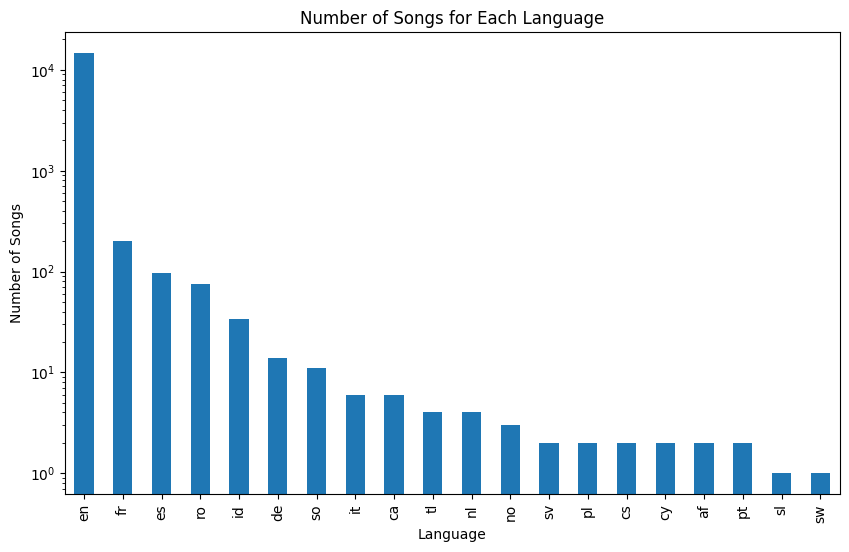

In [9]:
language_counts = df['language'].value_counts()

plt.figure(figsize=(10, 6))
language_counts.plot(kind='bar', logy=True)
plt.title('Number of Songs for Each Language')
plt.xlabel('Language')
plt.ylabel('Number of Songs')
plt.show()

Genre representation has also changed with our filters as you can see in the following plot. There is more rock songs than any other as well but the scale was kept linear this time.

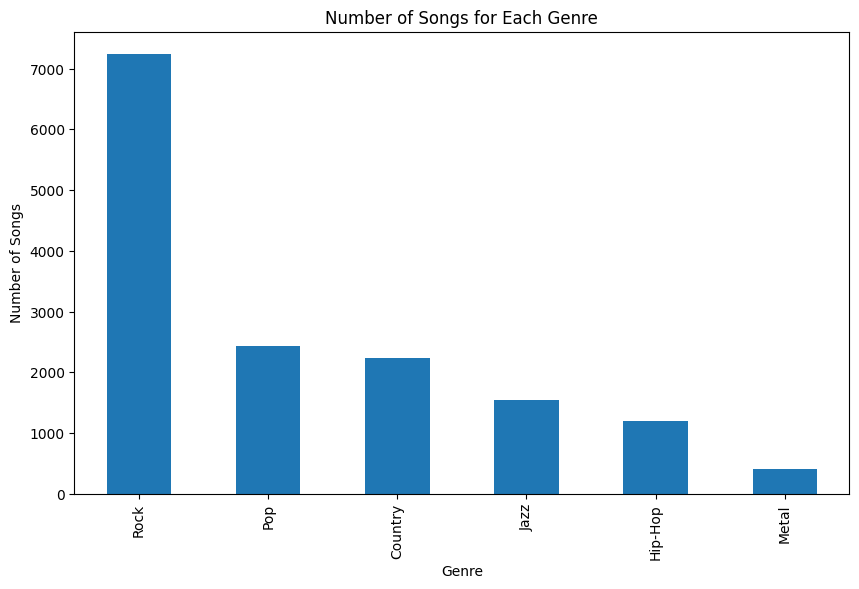

In [10]:
genre_counts = df['genre'].value_counts()

plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', logy=False)
plt.title('Number of Songs for Each Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Songs')
plt.show()

##  2. Model creation

Based on the information from the Data Science classes, I have decided to try logistic regression as the base model and then also try Multinomial Naive Bayes classificator. Based on information from Machine Learning for Greenhorns, I also wanted to try SVC and a simple MLP. However, I only trained a smaller model on them because it was slower and not much better.

I have tried training with various thresholds for the minimal number of songs of an interpreter. The models get worse when I keep more interpreters and the models get slower, however, the results are still interesting considering the number of interpreters (10% accuracy even with 150 interpreters). I have also tried GridSearchCV, but it did not affect the results much so in the end I decided to just keep the defaults.

I have used MLflow to track my models. You can see the summary of the latest, most representable results below. The first results are for the threshold at 400.

In [5]:

client = MlflowClient()
mlflow.set_tracking_uri('http://localhost:5000/')
runs = client.search_runs(experiment_ids="0")
data = []
for run in runs:
    metrics = run.data.metrics
    params = run.data.params
    tags = run.data.tags
    data.append({**metrics, **params, **tags})

df = pd.DataFrame(data)

df[['mlflow.runName', 'accuracy', 'top3_accuracy', 'average_cross_val_score', 'f1', 'precision', 'recall']][:5]

KeyError: "None of [Index(['mlflow.runName', 'accuracy', 'top3_accuracy',\n       'average_cross_val_score', 'f1', 'precision', 'recall'],\n      dtype='object')] are in the [columns]"

The accuracies of individual models are not very high. But that is rather because of the large number of possible targets. That's why we also have a top3 and top5 accuracy metric which measures how often the correct class is in the 3 or 5 most probable ones. Note that top5 mostly makes sense for interpreter which has hundreds of categories since there are just 5-8 categories in genre (5 for the smaller dataset, 8 for the larger one). But considering we have hundreds of interpreters, identifying the correct one with 10% probability and the interpreter being in top5 having even a much larger probability is not a bad result. We can confidently say that genre and interpreter can be predicted - however usable results would probably require more preprocessing and model tuning or predicting just on a smaller number of interpreters.

We can see that Multinomial Naive Bayes has the best top3/top5 accuracy, however for interpreter, it has quite low precision. But if our goal is to have reasonable candidates for interpreter that we can verify ourselves, that might be the best option. Surprisingly, for interpreter identification, Logistic regression was the best model and for genre identification it was as good as Naive Bayes. However, its accuracy does not improve as much as for the other two models when we consider top3 or top5.

The following models are for threshold at 200 with about 150 interpreters (just Naive Bayes and Logistic regression since they are much faster).

## 3. Model results

We will now see the details of the results of the Multinomial Naive Bayes classifier with the threshold at 200.

Below you can see some predictions the Logistic Regression makes for genre on the test set along with the correct target. I have chosen genre for illustration since we would probably need to study more samples if we wanted to understand the results of the interpreter model.

In [ ]:
logged_model = 'runs:/6b780e047bdf4ebe8384ef452b39e319/Genre Logistic Regression_model'
loaded_model = mlflow.pyfunc.load_model(logged_model)
test_df = pd.read_csv('test_data_Genre Multinomial Naive Bayes.csv')
predictions = loaded_model.predict(test_df.drop(['genre'], axis=1))
df_pred = pd.concat([test_df, pd.DataFrame(predictions, columns=['genre_predictions'])], axis=1)

In [ ]:
df_pred

,year,word_count,unique_word_count,average_word_length,alone,always,another,around,away,baby,...,language_sk,language_sl,language_so,language_sq,language_sv,language_sw,language_tl,language_tr,genre,genre_predictions
0,2006,0.044190,0.072414,0.185318,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,False,False,False,False,False,False,False,False,Rock,Rock
1,2006,0.190977,0.255172,0.160432,0.000000,0.0,0.0,0.000000,0.0,0.161352,...,False,False,False,False,False,False,False,False,Hip-Hop,Hip-Hop
2,2010,0.044190,0.049138,0.126603,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,False,False,False,False,False,False,False,False,Rock,Rock
3,2006,0.060569,0.101724,0.184924,0.824323,0.0,0.0,0.086162,0.0,0.162656,...,False,False,False,False,False,False,False,False,Rock,Rock
4,2006,0.030284,0.061207,0.207603,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,False,False,False,False,False,False,False,False,Rock,Rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9280,2008,0.054388,0.087069,0.149341,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,False,False,False,False,False,False,False,False,Rock,Rock
9281,2013,0.058405,0.110345,0.253769,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,False,False,False,False,False,False,False,False,Rock,Rock
9282,2006,0.095488,0.187931,0.202123,0.000000,0.0,0.0,0.000000,0.0,0.092973,...,False,False,False,False,False,False,False,False,Rock,Hip-Hop
9283,1995,0.043881,0.075862,0.169840,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,False,False,False,False,False,False,False,False,Rock,Rock


We can see in our example that most songs are Rock and they are mostly classified well. However there is one song misclassified as Hip-Hop.

Next, you can see the percentage of samples correctly classified for each genre.

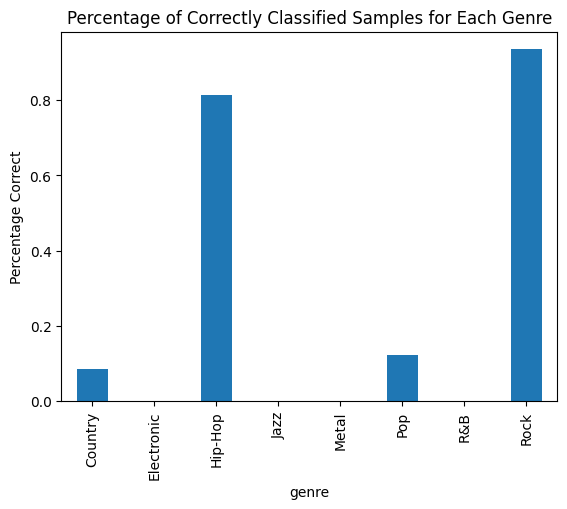

In [ ]:
df_pred['IsCorrect'] = df_pred['genre_predictions'] == df_pred['genre']

correct_percentages = df_pred.groupby('genre')['IsCorrect'].mean()

correct_percentages.plot(kind='bar')
plt.ylabel('Percentage Correct')
plt.title('Percentage of Correctly Classified Samples for Each Genre')
plt.show()

This plot is rather bad news - our model only learned to recognize certain genres and it mostly guesses Rock or Hip-Hop - so we have kind of a Rock/Hip-Hop recognizer. However that's no big surprise. For those results to be better, we would need to have a much larger representation for those other genres. We would definitely need to work on that in our further work if we wanted this model to be good.

## Summary

After preprocessing analyzing the data in the first report, we have addded some further preprocessing and featurization. Then we tried to train several models including logistic regression, Naive Bayes and SVC.

We have found out that all our models can predict the genre well enough and the predictions could be made even better with some further model tuning. However, predicting the interpreter when there are hundreds is a complex task, so our model were not able to achieve more than 10% accuracy. But considering that the correct interpreter was among the top 5 about 30% of the time, we can still consider such a model to be effective.

Acknowledgments: In the process of conducting the data analysis and building the models for this report, I utilized GitHub Copilot, an AI programming assistant powered by OpenAI's GPT-4 model. This tool provided assistance with code generation, debugging, and answering various programming-related queries. And with writing this acknowledgement. However, the rest of text is fully my work.